In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#한글폰트
import platform
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm

plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    f_path = '/Library/Fonts/Arial Unicode.ttf'
elif platform.system() == 'Windows':
    f_path = 'c:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

print('Hangul font is set!')

Hangul font is set!


# 시각화

## 부동산

### 데이터를 월 단위로 분할

In [42]:
def ym(date):
    return date[:-3]

def to_ym(df):
    df_ym = df
    df_ym['period'] = df_ym['period'].apply(ym)
    df_ym = df_ym.groupby('period').mean()
    df_ym['총합'] = df_ym.sum(axis=1)
    return df_ym


In [ ]:
# 검색량 변화 (서울 전체 대비)
df_total = pd.read_csv('data/검색량/총검색량.csv')
df_ym = to_ym(df_total)
df_rate = df_ym.div(df_ym['총합'], axis=0)


### 시각화

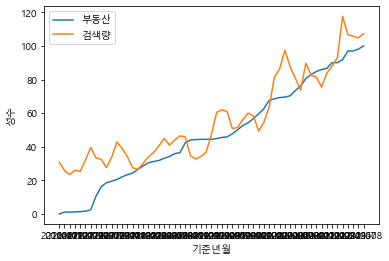

In [49]:
# 부동산 매매가 변화
df_price = pd.read_csv('data/부동산/매매평균가.csv')
df_price = df_price.set_index('기준년월')

# Scaling
df_p_rate = 100 * (df_price - df_price.iloc[0]) / (df_price.iloc[-1] - df_price.iloc[0])
df_rate *= 1000

# 시각화
sns.lineplot(x=df_p_rate.index, y='성수', label = '부동산', data=df_p_rate)
sns.lineplot(x=df_p_rate.index, y='성수', label = '검색량', data=df_rate.loc[df_p_rate.index])

# 저장
# plt.savefig('data/부동산/성수.png'

## 지하철

In [60]:
def quater(date):
    ss = ['겨울', '봄', '여름', '가을']
    if month == 12:
        return ss[0]
    return ss[month//3]
    
def to_quater(df_sub):
    df_sub['분기'] = (df_sub['YearMonth']//100 % 100).astype(str) + '-' + ((df_sub['YearMonth']%100 -1)//3 + 1).astype(str)
    #df_sub['분기'] = df_sub['분기'].astype(str)
    df_sub = df_sub.groupby('분기').mean()
    return df_sub

def to_qt(date):
    month = date[5:7]
    year = date[2:4]
    qt = (int(month)-1)//3 + 1
    return year + '-' + str(qt)

### 검색량 데이터를 분기별로

In [62]:
df_qt = df_total
df_qt['분기'] = df_qt['period'].apply(to_qt)
df_qt = df_qt.groupby('분기').mean()
df_qt['총합'] = df_qt.sum(axis=1)

### 지하철 데이터를 분기별로

In [64]:
df_sub_e = pd.read_csv('data/지하철/을지로.csv')
df_sub = to_quater(df_sub_e)

### 시각화

Text(0.5, 1.0, '을지로')

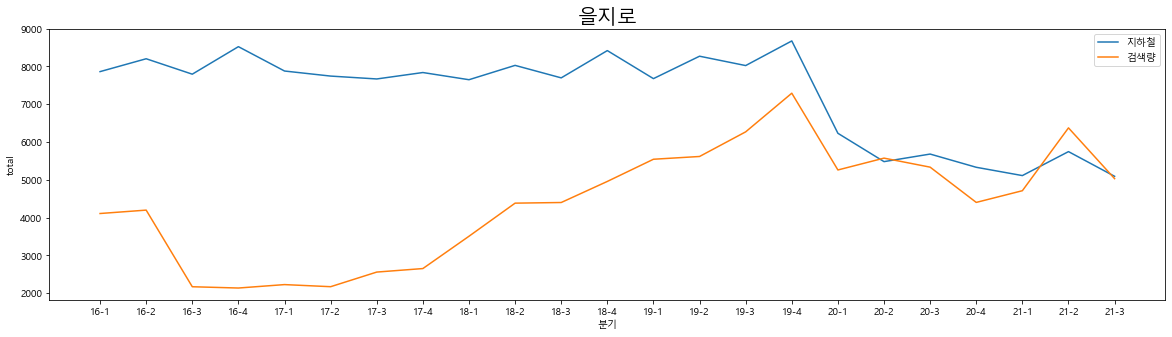

In [65]:
# Scaling
df_sub /= 1000

# 시각화
plt.figure(figsize=(20,5))
p = sns.lineplot(x = df_sub.index, y = 'total', label='지하철', data = df_sub)
p = sns.lineplot(x = df_qt.index, y = '을지로', label='검색량', data = df_qt)
plt.title('을지로', fontsize = 20)

# 저장
# plt.savefig('data/지하철/분기별_을지로.png')

## 연도별 변화량

### 전체 대비 지역별 변화량 계산

In [ ]:
# 전체 대비 지역별 변화량
df_total = pd.read_csv('data/검색량/총검색량.csv')
df_ym = to_ym(df_total)
df_rate = df_ym.div(df_ym['총합'], axis=0)
df_rate

### 연도별 변화량 비교

In [50]:
# 연도별 변화량 비교
df_year_rate = pd.DataFrame()
for year in range(2017,2021):
    start = f'{year}-01'
    end = f'{year+1}-01'
    df_year_rate[year] = df_rate.loc[end] / df_rate.loc[start]
df_year_rate[2021] = df_rate.iloc[-1]/df_rate.loc['2021-01']

df_year_rate['코로나이전'] = df_rate.loc['2020-01']/df_rate.loc['2017-01']
df_year_rate['코로나이후'] = df_rate.iloc[-1]/df_rate.loc['2020-01']
df_year_rate['전체'] = df_rate.iloc[-1]/df_rate.iloc[0]

# %단위로 변환
df_year_rate = round(df_year_rate*100).astype(int) - 100

df_year_rate = df_year_rate.rename(index={'종로':'익선'})
df_year_rate

### 히트맵

Text(86.90625, 0.5, 'place')

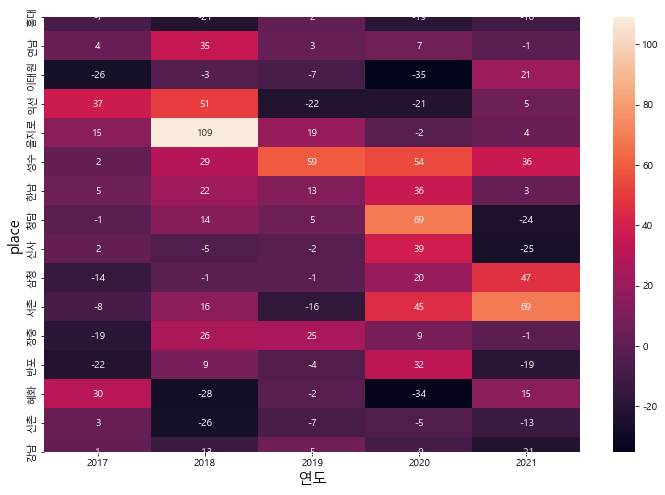

In [52]:
place = df_year_rate.index[:-1]
data = df_year_rate[range(2017,2022)]

# 시각화
plt.figure(figsize=(12,8))
p = sns.heatmap(data.loc[place], annot = True, fmt='d')
# plt.title('연도별 검색량 변화(%)', fontsize = 20)
p.set_xlabel("연도", fontsize = 15)
p.set_ylabel("place", fontsize = 15)

# 저장
#plt.savefig('data/검색량/히트맵_익선.png')

### 코로나 전 후 비교

Text(0, 0.5, '검색량 변화(%)')

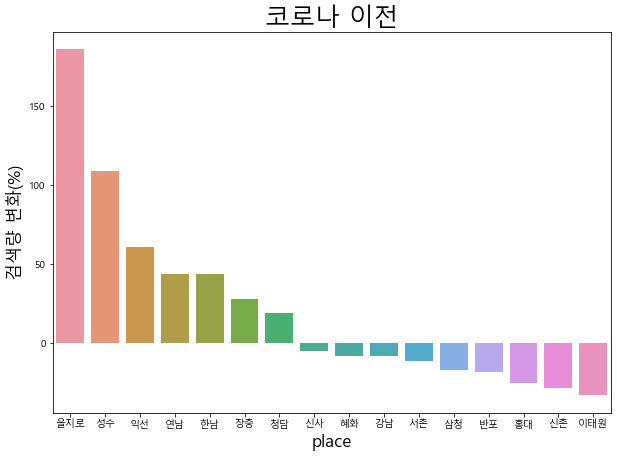

In [55]:
# 구간별 검색량 변화 비교
# 코로나 이전, 이후, 전체
data = df_year_rate[:-1].sort_values(by='코로나이전', ascending=False)

# 시각화
plt.figure(figsize=(10,7))
p = sns.barplot(x = data.index, y = '코로나이전', data = data)
plt.title('코로나 이전', fontsize = 25)
p.set_xlabel("place", fontsize = 17)
p.set_ylabel("검색량 변화(%)", fontsize = 17)

# 저장
#plt.savefig('data/검색량/코로나이전.png')

### point plot을 위한 데이터 프레임 새로 생성

In [56]:
data = df_year_rate[range(2017,2022)]
df_hist = pd.DataFrame(columns = ['place', '연도', '변화량'])
for place in data.index:
    for time in data.loc[place].index:
        if place == '총합':
            df_hist = df_hist.append({'place':'기준', '연도':time, '변화량':data.loc[place].loc[time]}, ignore_index=True)
        else:
            df_hist = df_hist.append({'place':place, '연도':time, '변화량':data.loc[place].loc[time]}, ignore_index=True)
df_hist

,place,연도,변화량
0,홍대,2017,-7
1,홍대,2018,-21
2,홍대,2019,2
3,홍대,2020,-19
4,홍대,2021,-10
...,...,...,...
80,기준,2017,0
81,기준,2018,0
82,기준,2019,0
83,기준,2020,0


### point plot

Text(0, 0.5, '검색량 변화(%)')

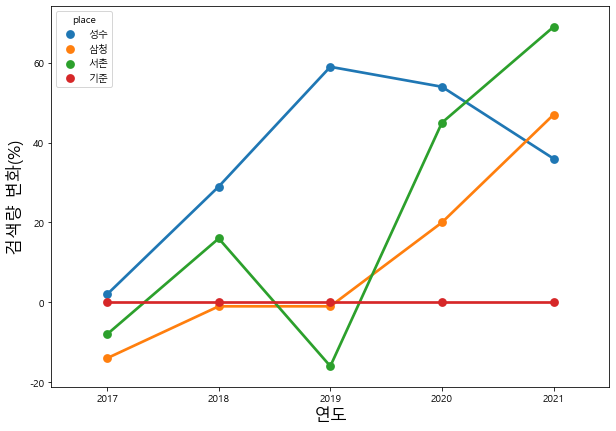

In [58]:
# plot할 데이터 추출
data = df_hist[(df_hist['place'] == '성수') | (df_hist['place'] == '서촌') | (df_hist['place'] == '삼청') | (df_hist['place'] == '기준')]

# 시각화
plt.figure(figsize=(10,7))
p = sns.pointplot(data = data, x="연도", y = "변화량", hue ="place")
#plt.title('핫플', fontsize = 25)
p.set_xlabel("연도", fontsize = 17)
p.set_ylabel("검색량 변화(%)", fontsize = 17)

# 저장
#plt.savefig('data/검색량/핫플_증가1.png')